Worth exploring
* Is SVM using OVR?
* Mystery of accuracy
* KNN
    * How to set right number of neighbors
    * What is KDTree
    * How to right metric of distance

# Definition

## Project Overview

* Project Origin: [Kaggle - Facebook V: Predicting Check Ins](https://www.kaggle.com/c/facebook-v-predicting-check-ins)
* Description: Facebook and Kaggle launched a machine learning engineering competition of identifying the correct place for check ins. For giving a flavor of what it takes to work with real data, Facebook created an artificial world consisting of more than 100,000 places located in a 10 km by 10 km square and data was fabricated to resemble location signals coming from mobile devices.
* Data sets:
    * train.csv, test.csv
        * row_id: id of the check-in event
        * x y: coordinates
        * accuracy: location accuracy 
        * time: timestamp
        * place_id: id of the business (this is the target I'm  predicting)

## Problem Statement

* Goal: The goal is to predict a ranked list of place a person would like to check in to.
* Proposed Solution:
    * TBD

## Metrics

* Prediction is evaluated according to the [Mean Average Precision @3](https://www.kaggle.com/wiki/MeanAveragePrecision)  (MAP@3)
\begin{equation*}
    MAP@3 = \frac{1}{|U|} \sum_{u=1}^{|U|} \sum_{k=1}^{min(3,n)} P(k)
\end{equation*}
where |U| is the number of check in events, P(k) is the precision at cutoff k, n is the number of predicted businesses.
* MAP is chosen because the prediction would be a list of ranked place and the order of place matters.

# Analysis

## Data Exploration

In [27]:
import math
import pandas as pd
import numpy as np
import time
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
# For plotting
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [3]:
print 'Size of training data: {}'.format(df_train.shape)
print 'Size of testing data: {}'.format(df_test.shape)
print 'Columns of data: {}'.format(df_train.columns.values)
print "Description of training data: \n"
print df_train.describe()

Size of training data: (29118021, 6)
Size of testing data: (8607230, 5)
Columns of data: ['row_id' 'x' 'y' 'accuracy' 'time' 'place_id']
Description of training data: 

                row_id                x                y         accuracy  \
count  29118021.000000  29118021.000000  29118021.000000  29118021.000000   
mean   14559010.000000         4.999770         5.001814        82.849125   
std     8405648.775656         2.857601         2.887505       114.751772   
min           0.000000         0.000000         0.000000         1.000000   
25%     7279505.000000         2.534700         2.496700        27.000000   
50%    14559010.000000         5.009100         4.988300        62.000000   
75%    21838515.000000         7.461400         7.510300        75.000000   
max    29118020.000000        10.000000        10.000000      1033.000000   

                  time      place_id  
count  29118021.000000  2.911802e+07  
mean     417010.364723  5.493787e+09  
std      231176.1464

### Coordinate
* We can see that the check-ins are roughly uniformly distributed on the map.
* Because the number of data is huge, only taking 1% of random sample to investigate the distribution of x and y. 

In [ ]:
sns.jointplot(data=df_train.sample(frac=0.01), x='x',y='y',kind='hex')

### Accuracy
* From the histogram of accuracy, we could know that majority of value is **under 200**.
* The meaning of accuracy is still vague.

In [ ]:
f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.set_title('Histogram of accuracy')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('Frequency')
df_train['accuracy'].hist(bins=100,ax=ax1)
ax2.set_title('Histogram of accuracy under 200')
ax2.set_xlim((0,200))
ax2.set_xlabel('Accuracy')
ax2.set_ylabel('Frequency')
df_train['accuracy'].hist(bins=100,ax=ax2)

### Place Ids
* From this section, we can know that there are a huge number of place ids and they are not uniformly distributed. This means that any algorithm which trains using a one vs all approach would not be the best choice on this dataset.
* What is "one vs all approach"?
    * This approach is training a single classifier per class for solving multiclass problems of n classes with the samples of that class as positive samples and all other samples as negatives. [( Reference-Wiki )](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest)

In [39]:
print "Number of unique place id: {}, roughly {:.3f} % of traing data.".format(len(df_train['place_id'].unique()), 
                                                                               len(df_train['place_id'].unique()) * 100.0 / df_train.shape[0])

Number of unique place id: 108390, roughly 0.372 % of traing data.


In [ ]:
plt.xlabel('Frequency')
plt.ylabel('Place ids')
df_train['place_id'].value_counts().head(5).plot.barh(title='Top 5 most common place ids', xlim=(0,2000)).invert_yaxis()

In [ ]:
plt.xlabel('Frequency')
plt.ylabel('Place ids')
df_train['place_id'].value_counts().tail(5).plot.barh(title='Bottom 5 most uncommon place ids', xlim=(0,5))

## Exploratory Visualization

### Explore Time

* Because the column of time is intentionally left vague without defining the unit of time, this section provides two methods to conclude the unit of time would be minute.
* Method 1: Converted the time to week at the top 3 place in order to find in order to visualize the weekly cycles. [(Reference)](https://www.kaggle.com/jsab16/facebook-v-predicting-check-ins/on-time/comments)

In [ ]:
# Top 1 place : 8772469670
time = df_train[df_train['place_id']==8772469670]['time']
time = time % (24*60*7)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Week cycle of 1st place')
time.hist(bins=100)

In [ ]:
# Top 2 place : 1623394281
time = df_train[df_train['place_id']==1623394281]['time']
time = time % (24*60*7)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Week cycle of 2nd place')
time.hist(bins=100)

In [ ]:
# Top 3 place : 1308450003
time = df_train[df_train['place_id']==1308450003]['time']
time = time % (24*60*7)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Week cycle of 3nd place')
time.hist(bins=100)

* Method 2: Used Fourier transform to extract the dominant frequency in order to find the period at the top 3 place. [(Reference)](https://www.kaggle.com/leonlu/facebook-v-predicting-check-ins/another-way-to-know-the-time-definition/comments)

In [ ]:
# Top 1 place : 8772469670
time = df_train[df_train['place_id']==8772469670]['time']
hist = np.histogram(time,5000)
hist_fft = np.absolute(np.fft.fft(hist[0]))

plt.plot(hist_fft)
plt.xlim([0,1000])
plt.title('FFT of event time histogram at 1st place')
plt.xlabel('1/T')
plt.grid(True)
plt.show()

print "1st period: {}, close to 10080 minutes a week.".format(time.max() / (hist_fft[2:200].argmax()+2.0))
print "2nd period: {}, close to 1440 minutes a day.".format(time.max() / (hist_fft[400:600].argmax()+400.0))

In [ ]:
# Top 2 place : 1623394281
time = df_train[df_train['place_id']==1623394281]['time']
hist = np.histogram(time,5000)
hist_fft = np.absolute(np.fft.fft(hist[0]))

plt.plot(hist_fft)
plt.xlim([0,1000])
plt.title('FFT of event time histogram at 1st place')
plt.xlabel('1/T')
plt.grid(True)
plt.show()

print "1st period: {}, close to 10080 minutes a week.".format(time.max() / (hist_fft[2:200].argmax()+2.0))
print "2nd period: {}, close to 1440 minutes a day.".format(time.max() / (hist_fft[400:600].argmax()+400.0))

In [ ]:
# Top 3 place : 1308450003
time = df_train[df_train['place_id']==1308450003]['time']
hist = np.histogram(time,5000)
hist_fft = np.absolute(np.fft.fft(hist[0]))

plt.plot(hist_fft)
plt.xlim([0,1000])
plt.title('FFT of event time histogram at 1st place')
plt.xlabel('1/T')
plt.grid(True)
plt.show()

print "1st period: {}, close to 10080 minutes a week.".format(time.max() / (hist_fft[2:200].argmax()+2.0))
print "2nd period: {}, close to 1440 minutes a day.".format(time.max() / (hist_fft[300:500].argmax()+300.0))

### Explore small grid
* From this section, it could be found that adding dimension of time would help seperating clusters.
* By zooming in on the maps, I'm trying to explore the data clusters on the x and y coordinates.
* It seems that there are some clusters could be found on the coordinates, but it still has quite overlaps.
* Inspired by [Alexandru Papiu](https://www.kaggle.com/apapiu/facebook-v-predicting-check-ins/random-forest-on-a-few-blocks/comments)

In [ ]:
small_grid = df_train[(df_train['x']<0.1)&(df_train['y']<0.1)]
color = dict(zip(small_grid['place_id'].unique(), cm.rainbow(np.linspace(0,1,small_grid['place_id'].unique().shape[0]))))

In [ ]:
f, ax = plt.subplots()
for place, group in small_grid.groupby('place_id'):
    group.plot(ax=ax, kind='scatter', x='x', y='y', color=color[place])
ax.set_title('Check-ins colored by place_id')
plt.show()

It could be found that the clusters are more easy to be seperated on some specific hour, because check-ins appear more often on specific hour for some specific places.

In [ ]:
f, (ax1,ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,10))
for place, group in small_grid.groupby('place_id'):
    group.plot(ax=ax1, kind='scatter', x='x', y='hour', color=color[place])
    group.plot(ax=ax2, kind='scatter', x='y', y='hour', color=color[place])
ax1.set_title('Place_ids by x and hour')
ax2.set_title('Place_ids by y and hour')
plt.show()

From the below histogram, we could see the check-ins on these two places are almost complement on dimension of time, one is popular at morning and the other is popular at night. This could help us double check the idea of adding the dimensio of time.

In [ ]:
f, (ax1,ax2) = plt.subplots(nrows=2, sharey=True,figsize=(15,10))
df_train[df_train['place_id']==8772469670]['hour'].hist(bins=100,ax=ax1)
ax1.set_title('Histogram of check-ins on the 1st popular place')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Frequency')
df_train[df_train['place_id']==1623394281]['hour'].hist(bins=100,ax=ax2)
ax2.set_title('Histogram of check-ins on the 2nd popular place')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Frequency')

## Algorithms and Techniques
* Are the algorithms you will use, including any default variables/parameters in the project clearly defined?
* Are the techniques to be used thoroughly discussed and justified?
* Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?

Following are those algorithms I'm trying to use
* KNN (K-Nearest Neighbor)
    * Description:
        * When a prediction is required for a unseen data instance, the KNN algorithm will search through the training dataset for the k-most similar instances.
        * The similarity measure is dependent on the type of data. For real-valued data, the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) can be used. Other other types of data such as categorical or binary data, [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) can be used.
        * It's an non parametric learning algorithm, so it means that KNN does not make any assumptions on the underlying data distribution.
        * It is also a lazy algorithm. What this means is that it does not use the training data points to do any generalization.
    * Discussion
        * Since I do not have any assumptions on the data distribution, KNN could be the good start point.
        * Since the scale of feature values will have significant influence at calculating the similarity, the weight will be set based on trial and error. 
    * Reference
        * [Tutorial To Implement k-Nearest Neighbors in Python From Scratch](http://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/)
        * [A Detailed Introduction to KNN](https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/)
        * [K-Nearest Neighbors: dangerously simple](https://mathbabe.org/2013/04/04/k-nearest-neighbors-dangerously-simple/)
    

## Benchmark
* Has some result or value been provided that acts as a benchmark for measuring performance?
* Is it clear how this result or value was obtained (whether by data or by hypothesis)?

I use following shared methods on Kaggle forums as my benschmark
* [KNN by Sandro](https://www.kaggle.com/svpons/facebook-v-predicting-check-ins/grid-knn/output)
    * Leard Board Score : 0.56736

### Explore Accuracy

In [4]:
place_ranking = df_train['place_id'].value_counts()

In [5]:
df_train['log'] = np.log10(df_train['accuracy'])
df_test['log'] = np.log10(df_test['accuracy'])

In [46]:
data_by_place = df_train.groupby('place_id')

In [7]:
num_sections = 13
Sections = pd.cut(df_train['log'], bins=num_sections, right=False)
data = df_train.groupby(['place_id', Sections])
sections = Sections.values.categories.values

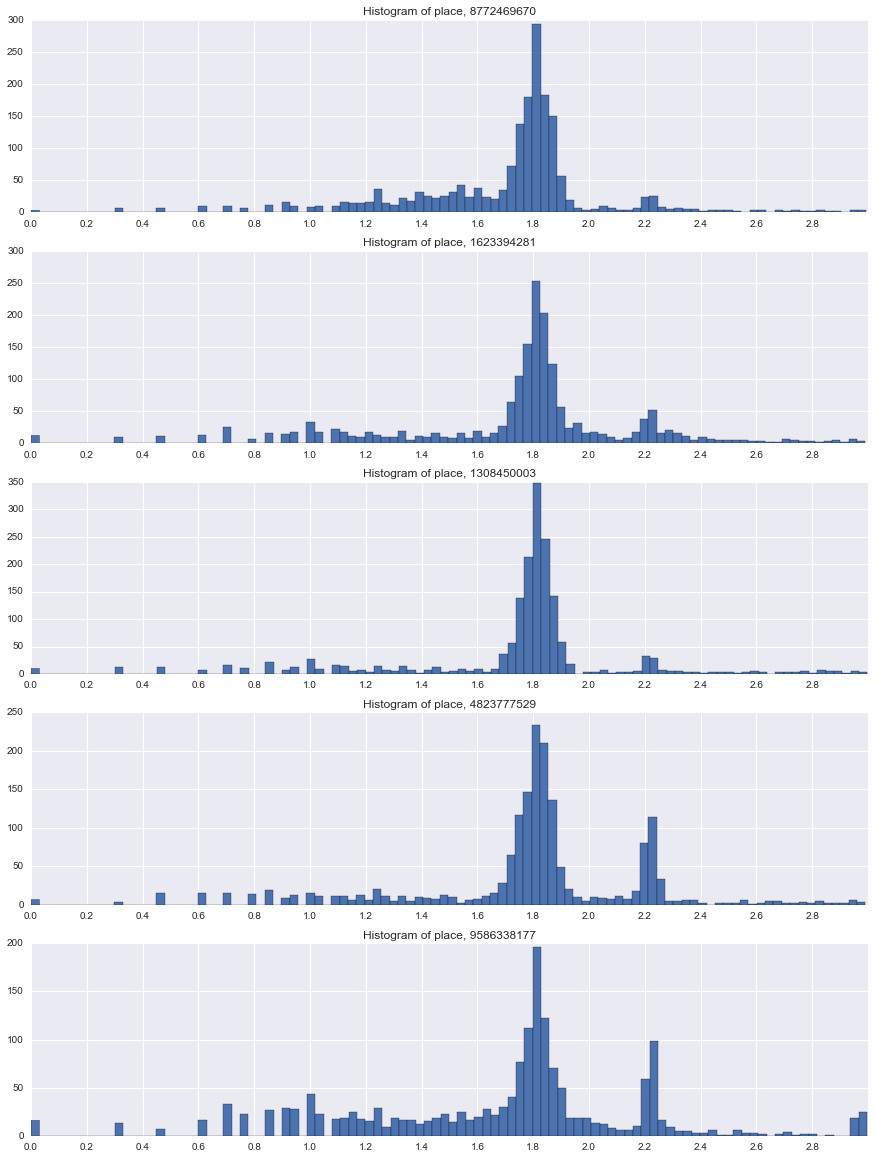

In [8]:
f, AX = plt.subplots(nrows=5,figsize=(15,20))
for place,ax in zip(place_ranking.head(3).index.values, AX):   
    data_by_place.get_group(place)['log'].hist(bins=100,ax=ax)
    ax.set_title('Histogram of log-accuracy on place {}'.format(place))
    ax.xaxis.set_ticks(np.arange(0,3,0.20))

In [ ]:
# Explore the difference of axis-y and median of axis-y on each group of place-id
for place in place_ranking.index.values:
    group = data_by_place.get_group(place)
    median = group['y'].median()
    group['diff-y'] = group['y'] - median

In [21]:
df_train['sin'] = np.pi*df_train['hour']/24.0
# df_train['cos'] = np.cos(np.pi*df_train['hour']/24)

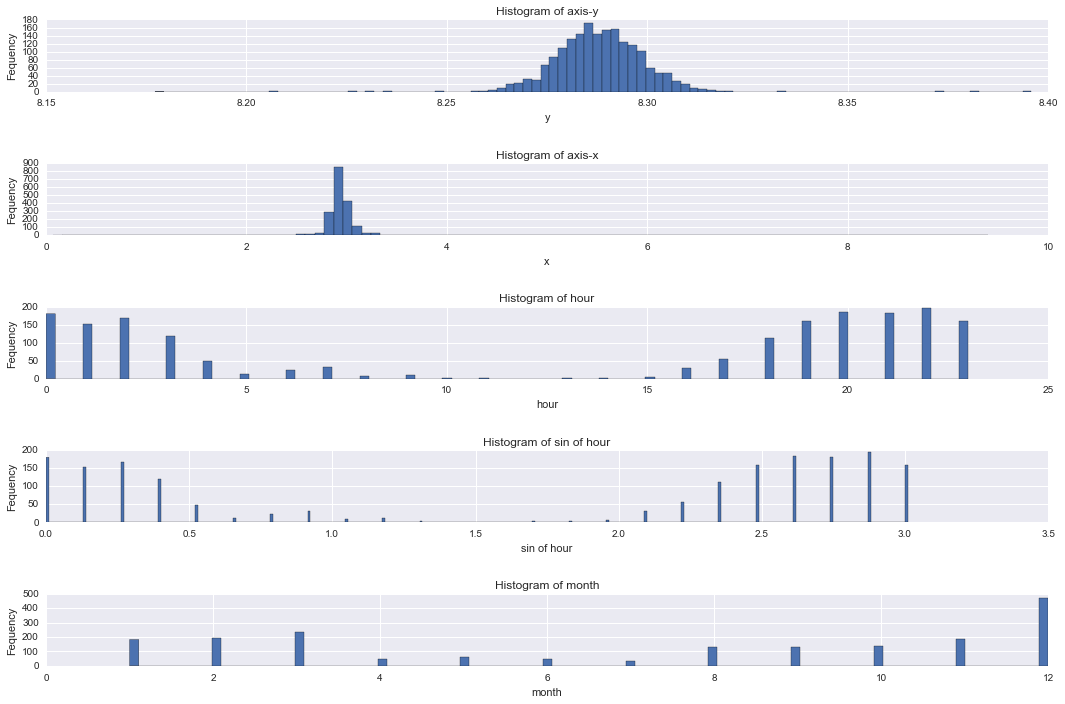

In [23]:
place = place_ranking.head(1).index.values[0]
f, AX = plt.subplots(nrows=5,figsize=(15,10))
data_by_place.get_group(place)['y'].hist(bins=100,ax=AX[0])
AX[0].set_title('Histogram of axis-y')
AX[0].set_xlabel('y')
AX[0].set_ylabel('Fequency')
data_by_place.get_group(place)['x'].hist(bins=100,ax=AX[1])
AX[1].set_title('Histogram of axis-x')
AX[1].set_xlabel('x')
AX[1].set_ylabel('Fequency')
data_by_place.get_group(place)['hour'].hist(bins=100,ax=AX[2])
AX[2].set_title('Histogram of hour')
AX[2].set_xlabel('hour')
AX[2].set_ylabel('Fequency')
data_by_place.get_group(place)['sin'].hist(bins=300,ax=AX[3])
AX[3].set_title('Histogram of sin of hour')
AX[3].set_xlabel('sin of hour')
AX[3].set_ylabel('Fequency')
data_by_place.get_group(place)['month'].hist(bins=100,ax=AX[4])
AX[4].set_title('Histogram of month')
AX[4].set_xlabel('month')
AX[4].set_ylabel('Fequency')
plt.tight_layout(h_pad=2)

In [ ]:
plt.subplot(1,2,1)
plt.scatter(data_by_place.loc[1308450003]['x'], data_by_place.loc[1308450003]['accuracy'])
plt.xlabel('x')
plt.ylabel('accuracy')
plt.subplot(1,2,2)
plt.scatter(data_by_place.loc[1308450003]['y'], data_by_place.loc[1308450003]['accuracy'])
plt.xlabel('y')
plt.ylabel('accuracy')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Methodology

## Data Preprocessing

Since it has been found that the unit of time is minute, we could add more fields related with time, which are **hour, weekday, month, year**.

In [3]:
def add_time(df_train, df_test):
    # This initial data is randomly setted, so there will be a shift if it's wrong date.
    initial_date = np.datetime64('2014-01-01T01:01', dtype='datetime64[m]')
    # Training data
    time = pd.DatetimeIndex(df_train['time'] + initial_date)
    df_train['minute'] = time.minute
    df_train['hour'] = time.hour
    df_train['weekday'] = time.weekday
    df_train['day'] = time.dayofyear
    df_train['month'] = time.month
    df_train['year'] = time.year - 2013
    # Testing data
    time = pd.DatetimeIndex(df_test['time'] + initial_date)
    df_test['minute'] = time.minute
    df_test['hour'] = time.hour
    df_test['weekday'] = time.weekday
    df_test['day'] = time.dayofyear
    df_test['month'] = time.month
    df_test['year'] = time.year - 2013
    return df_train, df_test

df_train, df_test = add_time(df_train, df_test)

Dividing the whole map into small cells and labeling the number on each cell, which is **grid_cell**.

In [6]:
def add_grid_cell(df_train, df_test, n_cell_x, n_cell_y):
    eps = 0.00001
    size_x = 10.0 / n_cell_x
    size_y = 10.0 / n_cell_y
    # Training data
    pos_x = (np.where(df_train['x'].values < eps, 0, df_train['x'].values - eps) / size_x).astype(int)
    pos_y = (np.where(df_train['y'].values < eps, 0, df_train['y'].values - eps) / size_y).astype(int)
    df_train['grid_cell'] = pos_y * n_cell_x + pos_x
    # Testing data
    pos_x = (np.where(df_test['x'].values < eps, 0, df_test['x'].values - eps) / size_x).astype(int)
    pos_y = (np.where(df_test['y'].values < eps, 0, df_test['y'].values - eps) / size_y).astype(int)
    df_test['grid_cell'] = pos_y * n_cell_x + pos_x
    return df_train, df_test

## Implementation

In [7]:
def generate_submission(df_aux, fname):
    print 'Generating submission file ...'
    ds_sub = df_aux['place1'].str.cat([df_aux['place2'], df_aux['place3']], sep=' ')
    ds_sub.name = 'place_id'
    ds_sub.to_csv(fname, index=True, header=True, index_label='row_id')

### KNN

In [85]:
# Adding grid id
n_cell_x = 20 # The number of cells on axis-x.
n_cell_y = 40 # The number of cells on axis-y.
df_train, df_test = add_grid_cell(df_train, df_test, n_cell_x, n_cell_y)

# Feature Engineering 
fw = {'x':500, 'y':1000, 'hour':4, 'weekday':3, 'day':1.0/22, 'month':2, 'year':10}
# Training data
for col in fw:
    df_train[col] = df_train[col]*fw[col]
# Testing data
for col in fw:
    df_test[col] = df_test[col]*fw[col]

In [119]:
from sklearn.neighbors import KNeighborsClassifier
# Train each cell by KNN
def process_one_cell_KNN(df_train, df_test, cell_id, th):
    # Select the specific cell with cell_id
    df_train_cell = df_train.loc[df_train['grid_cell'] == cell_id]
    # Select the place ids in the cell for training if the number of place id is higher than the threshold
    place_counts = df_train_cell['place_id'].value_counts()
    mask = (place_counts[df_train_cell['place_id']] >= th).values
    df_train_cell = df_train_cell.loc[mask]
    
    df_test_cell = df_test.loc[df_test['grid_cell'] == cell_id]
    row_ids = df_test_cell.index
    
    # Mapping place ids into values between 0 and n_classes-1
    le = LabelEncoder()
    y_train = le.fit_transform(df_train_cell['place_id'].values)
    X_train = df_train_cell[['x', 'y', 'hour', 'weekday', 'day', 'month', 'year']].values
    X_test = df_test_cell[['x', 'y', 'hour', 'weekday', 'day', 'month', 'year']].values
    
    params = {'n_neighbors':25, 'weights':'distance', 'metric':'manhattan'}
    clf = KNeighborsClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    # Reverse sorting and taking the top 3 place ids
    pred_labels = le.inverse_transform(np.argsort(y_pred, axis=1)[:,::-1][:,:3])
    return pred_labels, row_ids

# Processing each grid cell on the map
def process_grid_KNN(df_train, df_test, th, num_cells, fname):
    preds = np.zeros((df_test.shape[0], 3), dtype=int)
    for cell_id in range(num_cells):
        if cell_id % 50 == 0:
            print "Progress: {:.2f}%".format(cell_id * 100.0 / num_cells)
        pred_labels, row_ids = process_one_cell_KNN(df_train, df_test, cell_id, th)
        preds[row_ids] = pred_labels
    
    df_aux = pd.DataFrame(preds, dtype=str, columns=['place1', 'place2', 'place3'])
    generate_submission(df_aux, fname)

In [130]:
th = 5 # The threshold of selecting the place ids in the cell for training
process_grid_KNN(df_train, df_test, th, n_cell_x*n_cell_y, 'sub_knn.csv')

Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Generating submission file ...


### Gaussian Naive Bayes

In [8]:
# Adding grid id
n_cell_x = 20 # The number of cells on axis-x.
n_cell_y = 40 # The number of cells on axis-y.
df_train, df_test = add_grid_cell(df_train, df_test, n_cell_x, n_cell_y)

In [47]:
data_by_place.get_group()

AttributeError: Cannot access attribute 'shape' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [44]:
from sklearn.naive_bayes import GaussianNB
def process_one_cell_GNB(df_train, df_test, cell_id):
    # Select the specific cell with cell_id
    df_train_cell = df_train.loc[df_train['grid_cell'] == cell_id]
    
    df_test_cell = df_test.loc[df_test['grid_cell'] == cell_id]
    row_ids = df_test_cell.index
    
    # Mapping place ids into values between 0 and n_classes-1
    le = LabelEncoder()
    y_train = le.fit_transform(df_train_cell['place_id'].values)
    X_train = df_train_cell[['x', 'y', 'log']].values
    X_test = df_test_cell[['x', 'y', 'log']].values
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    # Reverse sorting and taking the top 3 place ids
    pred_labels = le.inverse_transform(np.argsort(y_pred, axis=1)[:,::-1][:,:3])
    return pred_labels, row_ids

# Processing each grid cell on the map
def process_grid_GNB(df_train, df_test, num_cells, fname):
    start_time = time.time()
    preds = np.zeros((df_test.shape[0], 3), dtype=int)
    for cell_id in range(num_cells):
        if cell_id % 50 == 0:
            elaps = time.time() - start_time
            print "Progress: {:.2f}%, elapsed: {:.0f} minute {:.0f} seconds".format(cell_id * 100.0 / num_cells, elaps/60, elaps%60)
        pred_labels, row_ids = process_one_cell_GNB(df_train, df_test, cell_id)
        preds[row_ids] = pred_labels
    
    df_aux = pd.DataFrame(preds, dtype=str, columns=['place1', 'place2', 'place3'])
    generate_submission(df_aux, fname)

In [45]:
process_grid_GNB(df_train, df_test, n_cell_x*n_cell_y, 'sub_GNB.csv')

Progress: 0.00%, elapsed: 0 minute 0 seconds
Progress: 6.25%, elapsed: 4 minute 31 seconds
Progress: 12.50%, elapsed: 7 minute 53 seconds
Progress: 18.75%, elapsed: 10 minute 25 seconds
Progress: 25.00%, elapsed: 14 minute 53 seconds
Progress: 31.25%, elapsed: 18 minute 31 seconds
Progress: 37.50%, elapsed: 21 minute 55 seconds
Progress: 43.75%, elapsed: 24 minute 23 seconds
Progress: 50.00%, elapsed: 28 minute 57 seconds
Progress: 56.25%, elapsed: 31 minute 18 seconds
Progress: 62.50%, elapsed: 35 minute 32 seconds
Progress: 68.75%, elapsed: 38 minute 59 seconds
Progress: 75.00%, elapsed: 42 minute 32 seconds
Progress: 81.25%, elapsed: 45 minute 5 seconds
Progress: 87.50%, elapsed: 49 minute 31 seconds
Progress: 93.75%, elapsed: 52 minute 16 seconds
Generating submission file ...


## Refinement